In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import pmdarima as pm
import torch

In [21]:
df = pd.read_csv("ILI_estimate.csv")

df.sort_index(inplace=True)

# Reindex the DataFrame to fill in missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_reindexed = df.reindex(all_dates)

# Fill missing values with 0
df_filled = df_reindexed.fillna(0)

# Now df_filled can be used for further analysis or modeling
df.head()

/tmp/ipykernel_32438/1912514561.py:1: DtypeWarning: Columns (9,22,28,52,56,60,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ILI_estimate.csv")


,Unnamed: 0,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,...,Other Adverse Effects,Adverse Events,Did the patient get well?,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex
0,22,64f1f433b2767d0028a35601,2023-08-27T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,6512-GBLYPkL4hA,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-01T00:00:00+08:00,NaN,6512,Female
1,35,64b46258713e280028a2ecdc,2023-07-04T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,5545-nCx5EGKwQL,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-07-17T00:00:00+08:00,NaN,5545,NaN
2,78,64a3383e915942002861d1c4,2023-07-01T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,5134-1DbSktQDNh,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-07-04T00:00:00+08:00,NaN,5134,Female
3,92,64f41b05c8efaa00299598da,2023-08-31T00:00:00+08:00,Outpatient,Check-up,10 - 19,False,6626-uCq62jAtEW,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-03T00:00:00+08:00,NaN,6626,Male
4,96,64e748ff7795bc0028ed8a78,2023-07-28T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,6104-RiFZTwxhKs,False,NaN,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-08-24T00:00:00+08:00,NaN,6104,Female


<Axes: >

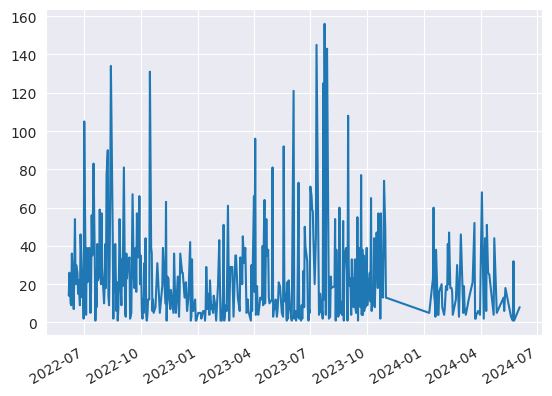

In [22]:
df['Date of Encounter'] = pd.to_datetime(df['Date of Encounter'])
df['Date of Encounter'].value_counts().sort_index().plot() 

In [23]:
year = df['Date of Encounter'].dt.isocalendar().year.astype(str)
week = df['Date of Encounter'].dt.isocalendar().week.astype(str)
day  = df['Date of Encounter'].dt.dayofyear.astype(str)

df['year'] = year
df['week'] = week
df['year-week'] = year + "-" + week
df['year-week-day'] = year + "-" + week + "-" + day

def convert_to_date(year_week):
    year, week = map(int, year_week.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = int((week - 1) / 4) + 1
    return f'{year}-W{week:02d}-DAY{month:02d}'

def convert_to_date_day(year_week_day):
    year, week, day = map(int, year_week_day.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = int((week - 1) / 4) + 1
    return f'{year}-W{week:02d}-MONTH{month:02d}-DAY{day}'

In [24]:
baseline_df = df[df['year'].isin(['2021','2022','2023'])]

In [46]:
data = baseline_df['Date of Encounter'].value_counts().sort_index().reset_index()
data.columns = ['Date of Encounter','count']
data

,Date of Encounter,count
0,2022-06-06 00:00:00+08:00,14
1,2022-06-07 00:00:00+08:00,26
2,2022-06-09 00:00:00+08:00,10
3,2022-06-10 00:00:00+08:00,9
4,2022-06-11 00:00:00+08:00,36
...,...,...
378,2023-10-26 00:00:00+08:00,13
379,2023-10-27 00:00:00+08:00,35
380,2023-10-28 00:00:00+08:00,74
381,2023-10-30 00:00:00+08:00,49


In [73]:
sorted_data = data.sort_values(by='Date of Encounter', ascending=True, axis=0)
sorted_data["Date of Encounter"] = sorted_data["Date of Encounter"].dt.strftime('%Y-%m-%d')
sorted_data.set_index('Date of Encounter', inplace=True)
all_dates = pd.date_range(start=sorted_data.index.min(), end=sorted_data.index.max(), freq='D').strftime('%Y-%m-%d')
sorted_data_reindexed = sorted_data.reindex(all_dates)
sorted_data_filled = sorted_data_reindexed.fillna(0)
sorted_data_filled.index

Index(['2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
       '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
       ...
       '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
       '2023-10-27', '2023-10-28', '2023-10-29', '2023-10-30', '2023-10-31'],
      dtype='object', length=513)

In [74]:
def fill_values(data, filled_data):
    data_date = data.index
    filled_data_date = filled_data.index
    counter = 0
    for i in range(len(filled_data)):
        print(filled_data_date[i], data_date[counter])
        if filled_data_date[i] == data_date[counter]:
            filled_data.iloc[i] = data.iloc[counter]
            counter += 1
    
    return filled_data

In [75]:
sorted_data.index

Index(['2022-06-06', '2022-06-07', '2022-06-09', '2022-06-10', '2022-06-11',
       '2022-06-13', '2022-06-14', '2022-06-16', '2022-06-17', '2022-06-18',
       ...
       '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25',
       '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-30', '2023-10-31'],
      dtype='object', name='Date of Encounter', length=383)

In [76]:
filled_data =fill_values(sorted_data, sorted_data_filled)
filled_data

2022-06-06 2022-06-06
2022-06-07 2022-06-07
2022-06-08 2022-06-09
2022-06-09 2022-06-09
2022-06-10 2022-06-10
2022-06-11 2022-06-11
2022-06-12 2022-06-13
2022-06-13 2022-06-13
2022-06-14 2022-06-14
2022-06-15 2022-06-16
2022-06-16 2022-06-16
2022-06-17 2022-06-17
2022-06-18 2022-06-18
2022-06-19 2022-06-20
2022-06-20 2022-06-20
2022-06-21 2022-06-21
2022-06-22 2022-06-22
2022-06-23 2022-06-23
2022-06-24 2022-06-24
2022-06-25 2022-06-25
2022-06-26 2022-06-27
2022-06-27 2022-06-27
2022-06-28 2022-06-28
2022-06-29 2022-06-29
2022-06-30 2022-06-30
2022-07-01 2022-07-01
2022-07-02 2022-07-02
2022-07-03 2022-07-04
2022-07-04 2022-07-04
2022-07-05 2022-07-05
2022-07-06 2022-07-06
2022-07-07 2022-07-07
2022-07-08 2022-07-08
2022-07-09 2022-07-09
2022-07-10 2022-07-11
2022-07-11 2022-07-11
2022-07-12 2022-07-12
2022-07-13 2022-07-13
2022-07-14 2022-07-14
2022-07-15 2022-07-15
2022-07-16 2022-07-16
2022-07-17 2022-07-18
2022-07-18 2022-07-18
2022-07-19 2022-07-19
2022-07-20 2022-07-20
2022-07-21

,count
2022-06-06,14.0
2022-06-07,26.0
2022-06-08,0.0
2022-06-09,10.0
2022-06-10,9.0
...,...
2023-10-27,35.0
2023-10-28,74.0
2023-10-29,0.0
2023-10-30,49.0


In [80]:
data

,index,count
0,2022-06-06,14.0
1,2022-06-07,26.0
2,2022-06-08,0.0
3,2022-06-09,10.0
4,2022-06-10,9.0
...,...,...
508,2023-10-27,35.0
509,2023-10-28,74.0
510,2023-10-29,0.0
511,2023-10-30,49.0


In [83]:
data = filled_data.reset_index()
data.columns = ['Date of Encounter','count']
data['Date of Encounter'] = pd.to_datetime(data['Date of Encounter'])
year = data['Date of Encounter'].dt.isocalendar().year.astype(str)
week = data['Date of Encounter'].dt.isocalendar().week.astype(str)
day  = data['Date of Encounter'].dt.dayofyear.astype(str)

data['year'] = year
data['week'] = week
data['year-week'] = year + "-" + week
data['year-week-day'] = year + "-" + week + "-" + day


len(data["year-week-day"].unique())

513

In [8]:
data['week'] = data['year-week'].apply(convert_to_date)
data.set_index('week', inplace=True)

data.head()

,Date of Encounter,count,year,year-week,year-week-day
week,,,,,
2022-W23-DAY06,2022-06-06 00:00:00+08:00,14,2022,2022-23,2022-23-157
2022-W23-DAY06,2022-06-07 00:00:00+08:00,26,2022,2022-23,2022-23-158
2022-W23-DAY06,2022-06-09 00:00:00+08:00,10,2022,2022-23,2022-23-160
2022-W23-DAY06,2022-06-10 00:00:00+08:00,9,2022,2022-23,2022-23-161
2022-W23-DAY06,2022-06-11 00:00:00+08:00,36,2022,2022-23,2022-23-162


(array([19174., 19236., 19297., 19358., 19417., 19478., 19539., 19601.,
        19662.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11')])

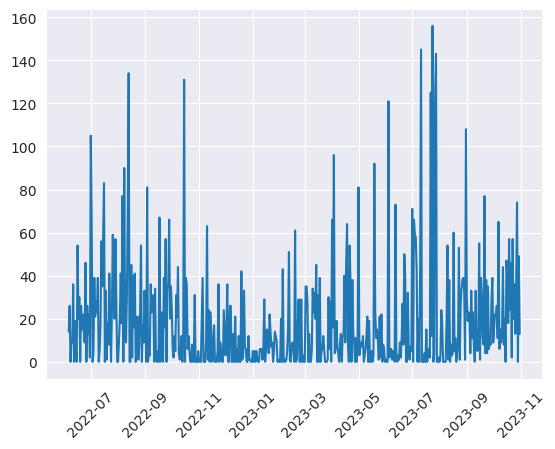

In [89]:
plt.plot(data["Date of Encounter"],data['count'])
plt.xticks(rotation=45)

In [ ]:
model = pm.auto_arima(
    data['count'], 
    start_p = 1,
    start_q = 1,
    max_p = 12,
    max_q = 12,
    seasonal = True,
    trace = True,
    m = 365
)

Performing stepwise search to minimize aic


AR(2) I(1) MA(1)
[y_(t+1)+y_(t)]/2

In [93]:
def detect_changes(df, threshold, arima_model):
    mean_ = df['count'].mean()
    dev_  = df['count'].std()
    
    df["warning_cusum"] = None
    df["warning_c1"] = None
    df["warning_c2"] = None
    df["warning_arima"] = None

    # Initialize C1 and C2
    df['C1'] = 0.0
    df['C2'] = 0.0

    counter = 0

    for i, row in df.iterrows():
        change_ = max(0, row["count"] - mean_)

        if change_ > threshold * dev_:
            df.at[i,"warning_cusum"] = 1
        else:
            df.at[i,"warning_cusum"] = 0

        # Calculate C1 and C2
        c1 = df.at[prev_idx, 'C1'] if counter > 0 else 0
        c2 = df.at[prev_idx, 'C2'] if counter > 0 else 0
                
        df.at[i, 'C1'] = max(0, row["count"] - mean_ + c1)
        df.at[i, 'C2'] = max(0, mean_ - row["count"] + c2)

        # Detect changes for C1 and C2
        df.at[i, 'warning_c1'] = (df.at[i, 'C1'] > threshold * dev_).astype(int)
        df.at[i, 'warning_c2'] = (df.at[i, 'C2'] > threshold * dev_).astype(int)

        prev_idx = i

        counter += 1

    df['predicted'] = arima_model.predict_in_sample()

    df['warning_arima'] = (df['count'] - df['predicted'] > threshold * np.std(df['count'] - df['predicted'])).astype(int)

    return df

In [94]:
data_ = detect_changes(data, threshold = 2, arima_model = model)

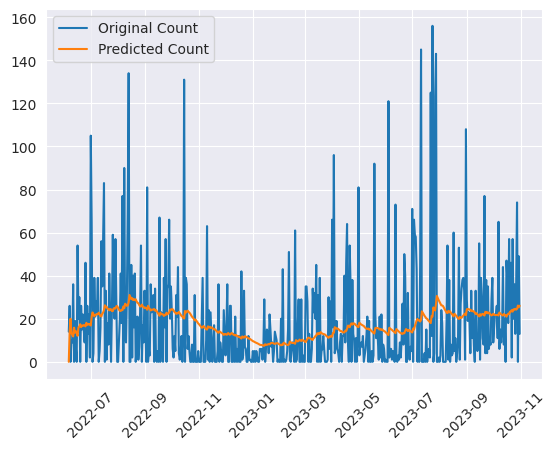

In [101]:
plt.plot(data["Date of Encounter"],data['count'])
plt.plot(data["Date of Encounter"],data['predicted'])
plt.xticks(rotation=45)
plt.legend(['Original Count', 'Predicted Count'])


In [ ]:
df["warning_arima"]

In [96]:
data_.describe()

,count,warning_arima,C1,C2,predicted
count,513.000000,513.000000,513.000000,513.000000,513.000000
mean,18.255361,0.046784,314.258811,787.042269,17.757432
std,24.880242,0.211381,280.061552,575.650622,5.842210
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,32.744639,50.021442,13.235008
50%,9.000000,0.000000,269.680312,999.419103,17.277698
75%,27.000000,0.000000,591.695906,1298.027290,22.691953
max,156.000000,1.000000,890.846004,1649.116959,31.023114


In [97]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  513
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2366.295
Date:                Sat, 20 Jul 2024   AIC                           4736.590
Time:                        17:42:40   BIC                           4745.067
Sample:                             0   HQIC                          4739.913
                                - 513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9686      0.010    -92.788      0.000      -0.989      -0.948
sigma2       601.8612     19.763     30.454      0.000     563.126     640.597
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1403.92
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
def plot_changes(df, warnings):
    plt.figure(figsize=(10, 6))

    plt.plot(df['count'], label='Count')

    colors = {'warning_cusum': 'red', 'warning_c1': 'green', 'warning_c2': 'purple', 'warning_arima': 'blue'}
    labels = {'warning_cusum': 'Change detected by Cumulative Sum Control', 'warning_c1': 'Change detected by C1', 'warning_c2': 'Change detected by C2', 'warning_arima': 'Change detected by ARIMA'}
    markers = {'warning_cusum': 'o', 'warning_c1': 'o', 'warning_c2': 's', 'warning_arima': 'x'}

    for warning in warnings:
        change_points = df[df[warning]==1]
        plt.scatter(change_points.index, change_points['count'], color=colors[warning], label=labels[warning], marker=markers[warning])

    # Set the x-ticks to the weeks where a change was detected by the selected warnings
    change_points_indices = set()
    for warning in warnings:
        change_points_indices = change_points_indices.union(set(df[df[warning]==1].index.values))
    plt.xticks(list(change_points_indices))

    #plt.xticks([])

    # Add labels and title
    plt.xlabel('Week')
    plt.ylabel('Count')
    plt.title('Influenza-Like Illnesses Warning Levels')

    # Add a legend
    plt.legend()

    plt.xticks(rotation=75)

    # Display the plot
    plt.show()

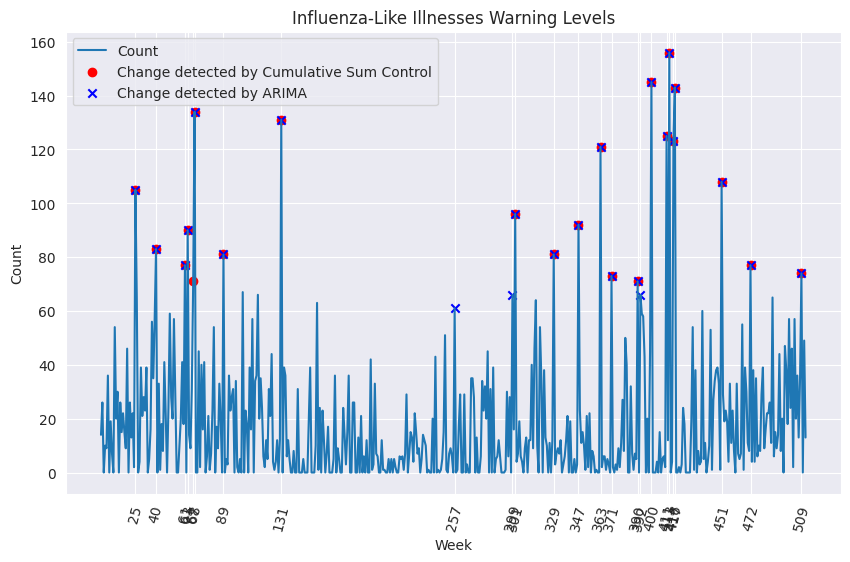

In [99]:
# Use the function
plot_changes(data_, ['warning_cusum', 'warning_arima'])